# Práctica 2 - Ejercicio 1

Asignatura: Programación para la Inteligencia Artificial

Alumno: Laura Mondéjar Ruiz

Este es el primer ejercicio de la Práctica 2 de Programación para la Inteligencia Artificial. Este ejercicio se debe entregar en un cuaderno de Jupyter separado del segundo.

El objetivo de este ejercicio es entrenar un modelo neuronal de clasificación usando solo neuronas lineales para el conjunto de datos CIFAR10. El conjunto está incluido en torchvision:

https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html

Dado el tamaño del conjunto de datos y los tiempos que puede tardar el entrenamiento, se requiere que el código permita elegir dispositivo de ejecución ('cpu' o 'cuda'). En el caso de elegir la opción de ejecución en GPU (y de haber una GPU disponible), el código deberá realizar el entrenamiento en GPU de manera eficiente.

Se espera el uso de las herramientas pertinentes tanto para completar el código como para realizar experimentos de los que se puedan extraer conclusiones sobre la capacidad del modelo entrenado. En el cuaderno se deben incluir los experimentos más relevantes.

Como conjunto de test se debe usar el conjunto de test íntegro que provee el conjunto de datos.

Se debe incluir una comparación de tiempos de entrenamiento en CPU y GPU.

El cuaderno entregado debe llamarse ApellidosNombrePractica2Ejercicio1.ipynb

Consejos:
*  Cambiar el optimizador SGD por Adam. Lo veremos en clase próximamente :)
*  Normalizar los colores de las imágenes al rango [0,1].


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/PIA/CIFAR10'

#Creo los conjuntos de entrenamiento, test y validación
train_dataset = datasets.CIFAR10(root=ruta, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root=ruta, train=False, download=True, transform=transforms.ToTensor())

def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset


train_dataset, val_dataset = split_dataset(train_dataset, split_share=0.8)
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")

def preload_data_to_tensors(dataloader):
    X_list, Y_list = [], []
    for x, y in dataloader:
        X_list.append(x)
        Y_list.append(y)
    X = torch.cat(X_list)
    Y = torch.cat(Y_list)
    return X, Y


#Bucle entrenamiento
def learning_loop(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, device):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []


  model = model.to(device)

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      # Entrenamiento
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        #Mover los datos al dispositivo
        x_true = x_true.to(device)
        y_true = y_true.to(device)

        y_pred = model(x_true)                              # Forward
        opt.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        opt.step()

      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      #Validación
      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0

        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:

            # Mover los datos al dispositivo
            x_val_true = x_val_true.to(device)
            y_val_true = y_val_true.to(device)

            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_accuracy = val_correct_answers/float(val_set_size)
          val_acc_list.append(val_accuracy.cpu())

          #Actualizar barra de progreso
          pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}", val_acc=f"{val_accuracy:.4f}")

  return model, epoch_loss_list, val_loss_list, val_acc_list

#PARAMETROS

batch_size = 1024
learning_rate = 1e-4
epochs = 200
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
validation_freq = 5

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Mounted at /content/drive
Número de ejemplos en entrenamiento: 39932
Número de ejemplos en validación: 10068
Número de ejemplos en test: 10000


**EXPERIMENTO 1**

-COMPARAR EL TIEMPO DE EJECUCIÓN EN CPU Y EN GPU -


CPU

epoch:: 100%|██████████| 200/200 [23:07<00:00,  6.94s/it, loss=0.7788676619529724]



 Tiempo final en CPU: 1387.4016427993774 segundos


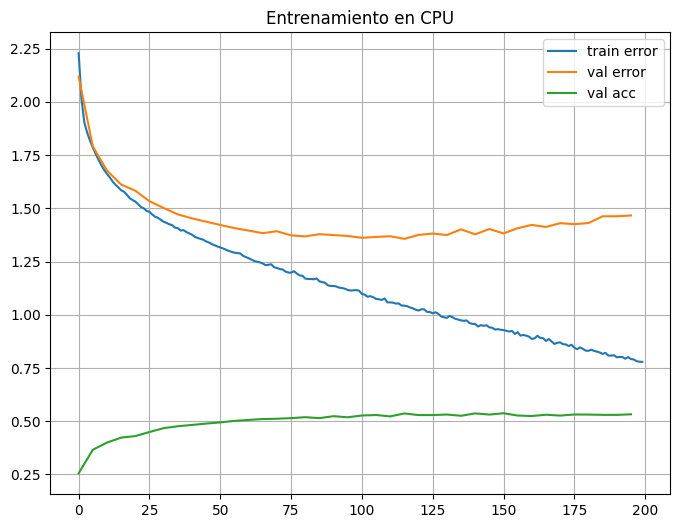

torch.Size([1024, 10])
torch.Size([1024])
torch.Size([10000])
torch.Size([10000])


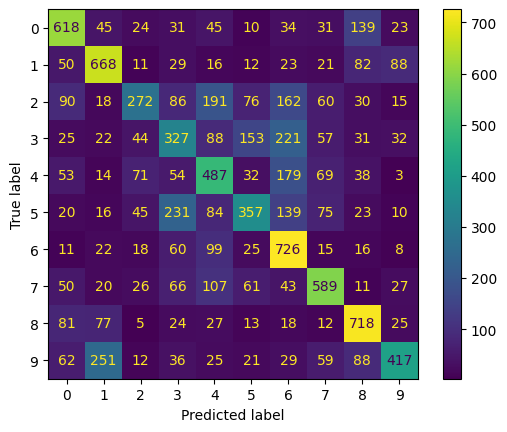

In [3]:
device_cpu = torch.device('cpu')

model_cpu = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32, 256), # Dimensiones de entrada: 3 canales * 32 alto * 32 ancho
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 10) # 10 clases en CIFAR10
).to(device_cpu)

 #Medición del tiempo
start_time_cpu = time.time()

model_cpu, train_loss_cpu, val_loss_cpu, val_acc_cpu= learning_loop(
    train_dataloader,
    val_dataloader,
    model_cpu,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq, device= device_cpu)

end_time_cpu = time.time()
total_time_cpu = end_time_cpu - start_time_cpu
print(f"\n Tiempo final en CPU: {total_time_cpu} segundos")

#Graficos Perdida y Accuracy
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_cpu)), train_loss_cpu, label="train error")
plt.plot(range(0, validation_freq*len(val_loss_cpu), validation_freq), val_loss_cpu, label="val error")
plt.plot(range(0, validation_freq*len(val_acc_cpu), validation_freq), val_acc_cpu, label="val acc")
plt.legend()
plt.grid(True)
plt.title("Entrenamiento en CPU")
plt.show()

# Matriz confusión
y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  val_x_true = val_x_true.to(device_cpu)
  y_test.append(val_y_true)
  y_pred.append(model_cpu(val_x_true).detach().cpu())

print(y_pred[0].shape)
print(y_test[0].shape)
y_test = torch.cat(y_test)
y_pred = torch.argmax(torch.cat(y_pred), dim=-1)
print(y_pred.shape)
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()


GPU

epoch:: 100%|██████████| 200/200 [01:35<00:00,  2.10it/s, loss=0.7787714004516602]

Tiempo final en GPU: 95.26063108444214 segundos


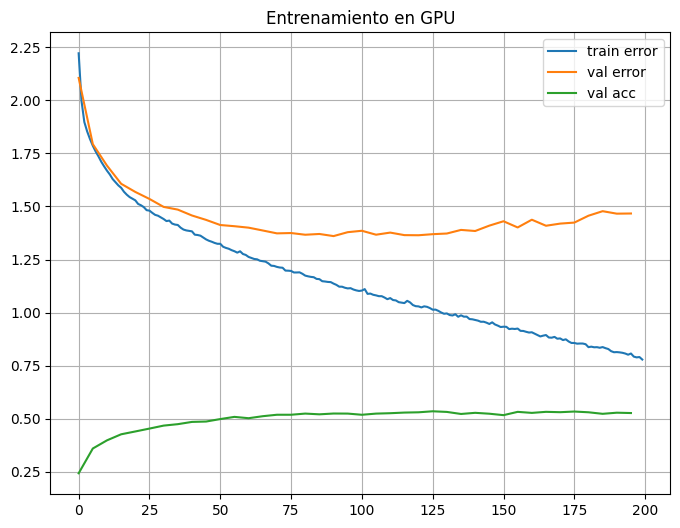

torch.Size([1024, 10])
torch.Size([1024])
torch.Size([10000])
torch.Size([10000])


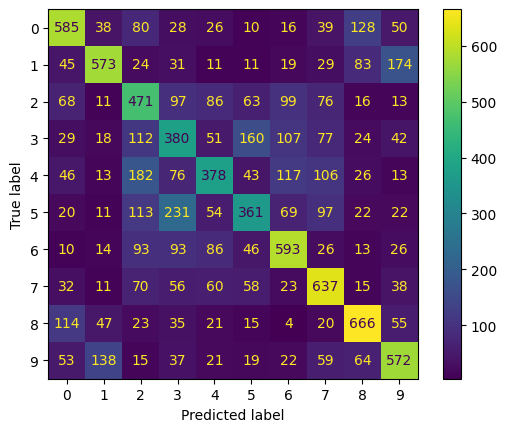

In [4]:
device_gpu = torch.device('cuda')

train_X, train_Y = preload_data_to_tensors(train_dataloader)
val_X, val_Y = preload_data_to_tensors(val_dataloader)

train_dataset_gpu = torch.utils.data.TensorDataset(train_X.to(device_gpu), train_Y.to(device_gpu))
val_dataset_gpu = torch.utils.data.TensorDataset(val_X.to(device_gpu), val_Y.to(device_gpu))

train_dataloader_gpu = DataLoader(train_dataset_gpu, batch_size=batch_size, shuffle=True)
val_dataloader_gpu = DataLoader(val_dataset_gpu, batch_size=batch_size, shuffle=True)


model_gpu = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32,256), # Dimensiones de entrada: 3 canales * 32 alto * 32 ancho
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 10) # 10 clases en CIFAR10
  ).to(device_gpu)

  #Medición del tiempo
start_time_gpu = time.time()

model_gpu, train_loss_gpu, val_loss_gpu, val_acc_gpu= learning_loop(
    train_dataloader_gpu,
    val_dataloader_gpu,
    model_gpu,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq, device = device_gpu)

end_time_gpu = time.time()
total_time_gpu = end_time_gpu - start_time_gpu
print(f"Tiempo final en GPU: {total_time_gpu} segundos")

#Graficos Perdida y Accuracy
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_gpu)), train_loss_gpu, label="train error")
plt.plot(range(0, validation_freq*len(val_loss_gpu), validation_freq), val_loss_gpu, label="val error")
plt.plot(range(0, validation_freq*len(val_acc_gpu), validation_freq), val_acc_gpu, label="val acc")
plt.legend()
plt.grid(True)
plt.title("Entrenamiento en GPU")
plt.show()

# Matriz confusión
y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  val_x_true = val_x_true.to(device_gpu)
  y_test.append(val_y_true)
  y_pred.append(model_gpu(val_x_true).detach())

print(y_pred[0].shape)
print(y_test[0].shape)
y_test = torch.cat(y_test)
y_pred = torch.argmax(torch.cat(y_pred), dim=-1).cpu()
print(y_pred.shape)
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

CONCLUSIÓN

In [5]:
#CONCLUSIÓN
print("Comparación de Tiempos")
print(f"Tiempo en CPU: {total_time_cpu} segundos")
print(f"Tiempo en GPU: {total_time_gpu} segundos")
print(f"La GPU fue {total_time_cpu/total_time_gpu} veces más rápida")

Comparación de Tiempos
Tiempo en CPU: 1387.4016427993774 segundos
Tiempo en GPU: 95.26063108444214 segundos
La GPU fue 14.564270958582451 veces más rápida


**EXPERIMENTO 2**

-Mejor accuracy-

epoch::  62%|██████▎   | 125/200 [14:47<08:52,  7.10s/it, loss=1.0100213289260864]

Early Stop.


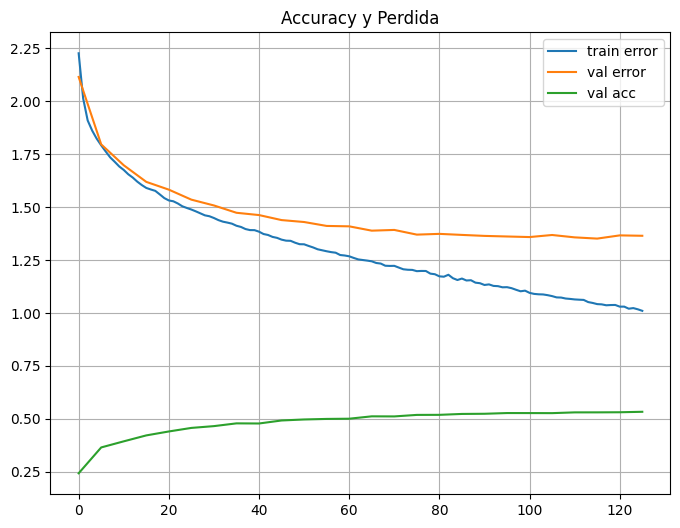

torch.Size([1024, 10])
torch.Size([1024])
torch.Size([10000])
torch.Size([10000])


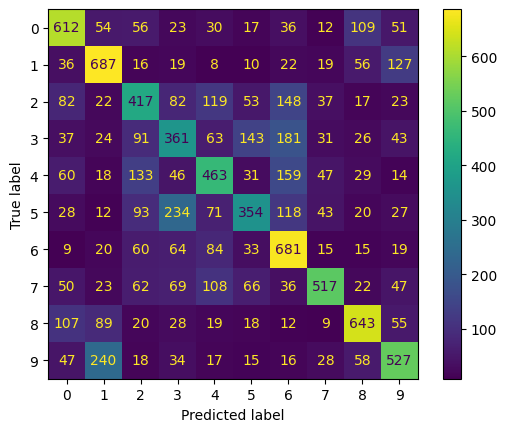

In [7]:
class Early_Stop():
  def __init__(self, patience=5, delta=0):
    self.patience = patience
    self.delta = delta
    self.best_val_loss = None
    self.no_val_improvement_times = 0
    self.stop = False

  def check_stop(self, val_loss):
    if self.best_val_loss is None or (val_loss + self.delta) < self.best_val_loss:
      self.best_val_loss = val_loss
      self.no_val_improvement_times = 0
    else:
      self.no_val_improvement_times += 1
      self.stop = self.no_val_improvement_times >= self.patience


def learning_loop_for_classification_with_early_stopping(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, early_stop):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        y_pred = model(x_true)                              # Forward
        opt.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        opt.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))

        early_stop.check_stop(val_loss)
        if early_stop.stop:
          print("Early Stop.")
          break

  return model, epoch_loss_list, val_loss_list, val_acc_list

patience = 5
delta = 0.01

model= torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32,256), # Dimensiones de entrada: 3 canales * 32 alto * 32 ancho
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 10) # 10 clases en CIFAR10
  )

early_stop = Early_Stop(patience = patience,
                        delta = delta)

model, train_loss, val_loss, val_acc= learning_loop_for_classification_with_early_stopping(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq, early_stop = early_stop)

#Graficos Perdida y Accuracy
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss)), train_loss, label="train error")
plt.plot(range(0, validation_freq*len(val_loss), validation_freq), val_loss, label="val error")
plt.plot(range(0, validation_freq*len(val_acc), validation_freq), val_acc, label="val acc")
plt.legend()
plt.grid(True)
plt.title("Accuracy y Perdida")
plt.show()

# Matriz confusión
y_pred = []
y_test = []
for val_x_true, val_y_true in test_dataloader:
  val_x_true = val_x_true.to(device_cpu)
  y_test.append(val_y_true)
  y_pred.append(model(val_x_true).detach().cpu())

print(y_pred[0].shape)
print(y_test[0].shape)
y_test = torch.cat(y_test)
y_pred = torch.argmax(torch.cat(y_pred), dim=-1)
print(y_pred.shape)
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()